In [1]:
import os

dataset_path = './D-Fire'
print(os.listdir(dataset_path))

['test', 'train']


In [2]:
TENSOR_SIZE = 128
BATCH_SIZE = 16
EPOCH_NUMBER = 3
LEARNING_RATE = 0.001

In this cell, we're setting up the necessary transformations for the images before feeding them into the model. These transformations will help with data augmentation, ensuring the model is more robust and generalizes better.

In [3]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose, Normalize, RandomHorizontalFlip, RandomRotation, ColorJitter

transform = Compose([
    Resize((TENSOR_SIZE, TENSOR_SIZE)),
    ToTensor(),
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=15),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In this cell, we define a custom dataset class called `FireClassificationDataset` by subclassing `torch.utils.data.Dataset`. This custom class will help us load the image and label pairs from the specified directories, as well as apply the necessary transformations. Since the label files are in the YOLO format, we need to read them manually to determine the labels for our classification problem:

1. If an image does not have a .txt file, it means it does not contain smoke or fire. In this case, we assign a label of 0.
2. If an image has a .txt file and its first character is 0 followed by bounding box coordinates, it means the image contains smoke.
3. If an image has a .txt file and its first character is 1 followed by bounding box coordinates, it means the image contains fire.

`class FireClassificationDataset(Dataset)`: We create a new class that inherits from Dataset.

`def __init__(self, img_dir, label_dir, transform=None)`: The constructor takes three arguments: the directory containing the images, the directory containing the labels, and an optional transformation to apply to the images.

`self.img_dir, self.label_dir, and self.transform`: We store the input arguments as instance variables for later use.

`self.image_filenames`: We list all the image filenames in the specified image directory.

`def __len__(self)`: This method returns the total number of images in the dataset.

`def __getitem__(self, index)`: This method is called to load an image-label pair at a given index:

1. We get the image filename at the specified index and construct the image and label file paths.
2. We open the image and convert it to an RGB format using the PIL.Image library.
3. We try to read the corresponding label file. If the file is not found, we assume the image does not contain smoke or fire and assign a label of 0.
4. If the label file is found, we check its first character to determine whether the image contains smoke (class_id = 0) or fire (class_id = 1).
We apply the specified transformation to the image if it is provided.
We return the transformed image and the corresponding label.

In [4]:
import os
from torch.utils.data import Dataset
from PIL import Image

class FireClassificationDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_filenames = os.listdir(img_dir)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        img_filename = self.image_filenames[index]
        img_path = os.path.join(self.img_dir, img_filename)
        img = Image.open(img_path).convert('RGB')

        label_path = os.path.join(self.label_dir, os.path.splitext(img_filename)[0] + '.txt')
        try:
            with open(label_path, 'r') as f:
                lines = f.readlines()
            # Check if there's any fire object (class_id = 1) in the image
            label = 1 if any(int(line.split()[0]) == 1 for line in lines) else 0
        except FileNotFoundError:
            print(f"Warning: Label file not found for image {img_filename}. Using default label 0.")
            label = 0

        if self.transform:
            img = self.transform(img)

        return img, label #img_filename (returning it causes some problems in to_device())


In [5]:
train_images_path = dataset_path + "/train/images"
train_labels_path = dataset_path + "/train/labels"

test_images_path = dataset_path + "/test/images"
test_labels_path = dataset_path + "/test/labels"

train_dataset = FireClassificationDataset(train_images_path, train_labels_path, transform=transform)
test_dataset = FireClassificationDataset(test_images_path, test_labels_path, transform=transform)

In [6]:
len(train_dataset)

17221

In [7]:
len(test_dataset)

4306

In [8]:
import torch
from torch.utils.data import random_split

validation_size = round(0.5 * len(test_dataset))
test_size = len(test_dataset) - validation_size

test_dataset, validation_dataset = random_split(test_dataset, [test_size, validation_size])

In [9]:
len(validation_dataset)

2153

In [10]:
len(test_dataset)

2153

In [11]:
from torch.utils.data.dataloader import DataLoader

batch_size = BATCH_SIZE
train_dataloader = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
validation_dataloader = DataLoader(validation_dataset, batch_size * 2, num_workers = 2, pin_memory = True)
test_dataloader = DataLoader(test_dataset, batch_size * 2, num_workers = 2, pin_memory = True)

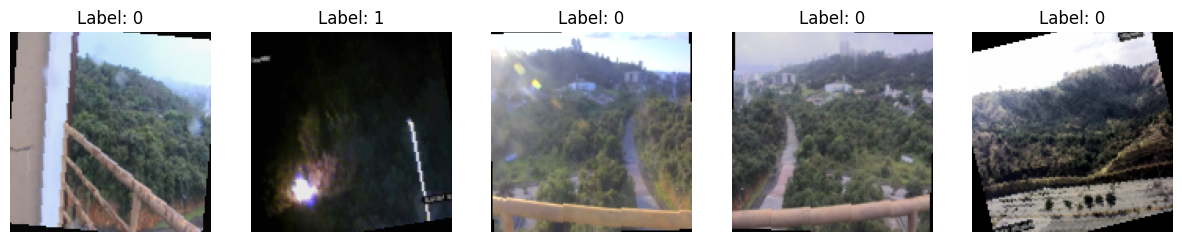

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def visualize_dataset(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    for i in range(num_samples):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()
        img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
        img = np.clip(img, 0, 255).astype(np.uint8)
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

visualize_dataset(train_dataset)


The images without fires are labeled as **0** above, the ones with fires are labels as **1**.

In this cell, we define an `ImageClassificationModel` class, which is a subclass of `torch.nn.Module`. This class will be the basis for our custom image classification model. We also define a helper function accuracy to calculate the `accuracy` of our model's predictions.

`class ImageClassificationModel(nn.Module)`: We create a new class that inherits from `torch.nn.Module`.

`def training_step(self, batch)`: This method takes a batch of images and labels, generates predictions using the model, and calculates the training loss using the cross-entropy loss function.

`def validation_step(self, batch)`: This method takes a batch of images and labels, generates predictions using the model, and calculates the validation loss and accuracy. It returns a dictionary containing both values.

`def validation_epoch_end(self, outputs)`: This method takes the outputs from the `validation_step` method and calculates the mean validation loss and accuracy across all batches. It returns a dictionary containing these values.

`def epoch_end(self, epoch, result)`: This method prints the training loss, validation loss, and validation accuracy at the end of each epoch.

`def accuracy(outputs, labels)`: This is a helper function that takes the model's output predictions and the true labels. It calculates the accuracy by comparing the predicted class labels to the true labels and returns the result as a torch tensor.

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationModel(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    # Generate predictions
    out = self(images)
    # Calculate loss
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    # Calculate accuracy
    acc = accuracy(out, labels)
    return {'validation_loss': loss.detach(), 'validation_accuracy': acc} 

  def validation_epoch_end(self, outputs):
      batch_losses = [x['validation_loss'] for x in outputs]
      # Combine losses
      epoch_loss = torch.stack(batch_losses).mean()
      batch_accs = [x['validation_accuracy'] for x in outputs]
      # Combine accuracies
      epoch_acc = torch.stack(batch_accs).mean()
      return {'validation_loss': epoch_loss.item(), 'validation_accuracy': epoch_acc.item()}

  def epoch_end(self, epoch, result):
      train_loss, val_loss, val_acc = result['train_loss'], result['validation_loss'], result['validation_accuracy']
      print(f"Epoch [{epoch}/{EPOCH_NUMBER}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In this cell, we define a `CNNModel` class, which is a subclass of `ImageClassificationModel`. This class implements a custom Convolutional Neural Network (CNN) architecture for our image classification task.

`class CNNModel(ImageClassificationModel)`: We create a new class that inherits from the previously defined ImageClassificationModel.

`def __init__(self)`: The constructor initializes the CNN architecture using `nn.Sequential`. The architecture consists of several convolutional layers with ReLU activation functions, max pooling layers, and fully connected layers. The final output layer has two neurons, corresponding to the two possible classes (0 for no smoke/fire and 1 for fire).

`def forward(self, xb)`: This method takes a batch of input images (xb) and passes it through the defined network to generate predictions.

`model = CNNModel()`: We create an instance of the `CNNModel` class.

`model`: We display the model's architecture to verify its structure.

In [14]:
class CNNModel(ImageClassificationModel):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(128 * int(TENSOR_SIZE / 2) * int(TENSOR_SIZE / 2), 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2))
        
    def forward(self, xb):
        return self.network(xb)


model = CNNModel()
model

CNNModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=524288, out_features=256, bias=True)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=128, bias=True)
    (17): ReLU()
    (18): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [15]:
def get_default_device():
    if torch.cuda.is_available():
        print('Using CUDA')
        return torch.device('cuda')
    else:
        print('Using CPU')
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataloader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dataloader)
    
device = get_default_device()
device

Using CUDA


device(type='cuda')

In [16]:
train_dataloader = DeviceDataloader(train_dataloader,  device)
validation_dataloader = DeviceDataloader(validation_dataloader, device)
test_dataloader = DeviceDataloader(test_dataloader, device)

In this cell, we define the `evaluate` and `fit` functions to perform model evaluation and training, respectively.

`@torch.no_grad()`: This decorator ensures that no gradients are computed during the evaluation, saving memory and computation time.

`def evaluate(model, validation_loader)`: This function takes the model and validation loader as inputs, performs model evaluation, and returns the validation loss and accuracy.

`def fit(epochs, lr, model, train_loader, validation_loader, opt_func=torch.optim.SGD)`: This function trains the model for a specified number of epochs using the given learning rate, model, train and validation loaders, and optimization function (default is SGD). It returns the training history.

Inside the `fit` function, we perform the following steps:

1. Clear GPU memory cache.
2. Initialize the optimizer.
3. Loop through the specified number of epochs.
4. Set the model to train mode.
5. Initialize an empty list for train_losses.
6. Loop through the batches in the train_loader.
7. Perform a training step and append the loss to train_losses.
8. Perform backpropagation and optimization.
9. Evaluate the model on the validation dataset.
10. Calculate the average training loss for the epoch.
11. Call the `epoch_end` method of the model to display training progress.
12. Append the results to the training history.

`model = to_device(model, device)`: Move the model to the appropriate device.

`evaluate(model, validation_dataloader)`: Perform an initial evaluation of the model to establish a baseline.

In [17]:
@torch.no_grad()
def evaluate(model, validation_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in validation_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, validation_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, validation_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

model = to_device(model, device)
evaluate(model, validation_dataloader)

: 

: 

In [ ]:
num_epochs = EPOCH_NUMBER
opt_func = torch.optim.Adam
lr = LEARNING_RATE

In [ ]:
history = fit(num_epochs, lr, model, train_dataloader, validation_dataloader, opt_func=opt_func)

In [ ]:
torch.save(model.state_dict(), 'image_classification_model.pth')